# Credit card fraud

In this notebook I explore two ways to deal with imbalanced data. One is using a weighted loss function and the second one is undersampling the more frequent class. The best recall I got is 0.95 with the f1 score 0.98. The recall and f1 depend on how the data gets randomized and split but in most cases you'll get recall score > 0.92.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Look at the data

Let's load our dataset and print out some basic statistics about it.

In [2]:
data_orig = pd.read_csv('./data/creditcard.csv')

print(data_orig.shape)
data_orig.describe()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


(284807, 31)
Positive samples:  (492, 31)
Negative samples:  (284315, 31)


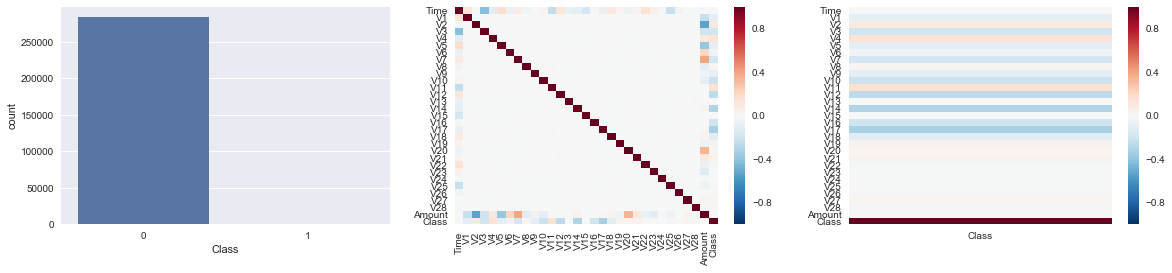

In [53]:
data = data_orig.copy()

plt.figure(figsize=(20,4))
plt.subplot(131)
sns.countplot(x='Class', data=data)
corr_matrix = data.corr()
feature_class_corr = pd.DataFrame(corr_matrix.loc['Class', data.columns])
plt.subplot(132)
sns.heatmap(corr_matrix)
plt.subplot(133)
sns.heatmap(feature_class_corr)

print(data.shape)
print('Positive samples: ', data[data['Class'] == 1].shape)
print('Negative samples: ', data[data['Class'] == 0].shape)

Based on the the table above, we can see that `Amount` column has much larger mean and standard deviation than other features. In the next step we'll rescale it so it has mean 0 and standard deviation 1. Correlation matrix shows us there is no or very little correlation between the `Time` column and fraud class so we'll get rid of it. 

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop('Time', axis=1, inplace=True)

feature_columns = data.columns.values.tolist()
feature_columns.remove('Class')
target = 'Class'

The data has already been preprocessed for us as features itself are first 28 principal components obtained from principal component analysis so we are good to continue.

### Dimensionality reduction

We can use PCA to reduce dimensionality of our dataset down to 2 dimensions so that we can plot it. This will tell us whether there is some separation between positive and negative class. The plot below shows first two principal components and we can see that fraudulent transactions are clustered in the lower left portion of the plot. 

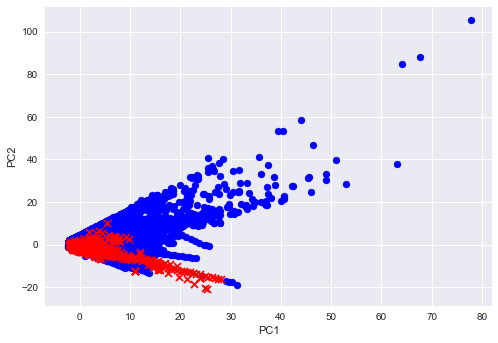

In [26]:
from sklearn.decomposition import PCA

reduced = PCA(n_components=2).fit_transform(data[feature_columns].values)

plt.figure()
plt.scatter(reduced[data[target] == 0, 0], reduced[data[target] == 0, 1], color='blue')
plt.scatter(reduced[data[target] == 1, 0], reduced[data[target] == 1, 1], color='red', marker='x')
plt.xlabel("PC1")
plt.ylabel("PC2")

### Train test split

SciKit learn provides a `train_test_split` method that split our data into trainig and test samples. It performs stratified sampling which means that the frequency of positive and negative samples is approximately the same for training data as well as for test data.

In [92]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data[feature_columns], data[target], test_size=0.3)
print('% fraud in population: ', data[data[target] == 1].shape[0] / data.shape[0] * 100)
print('Train - size:', train_y.shape[0], ', %fraud:', train_y[train_y == 1].shape[0] / train_y.shape[0] * 100)
print('Test - size:', test_y.shape[0], ', %fraud: ', test_y[test_y == 1].shape[0] / test_y.shape[0] * 100)

% fraud in population:  0.1727485630620034
Train - size: 199364 , %fraud: 0.1705423245922032
Test - size: 85443 , %fraud:  0.177896375361352


In [126]:
from sklearn import metrics

def model_metrics(model, test_X, test_y, rf=False):
    predictions = model.predict(test_X) 
    
    print(metrics.classification_report(test_y, predictions))
    
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    conf_mat = metrics.confusion_matrix(test_y, predictions)
    ax = sns.heatmap(conf_mat, annot=True)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    if rf:
        return
    
    probabilities = model.decision_function(test_X)
    fp_rate, tp_rate, _ = metrics.roc_curve(test_y, probabilities)
    auc = metrics.auc(fp_rate, tp_rate)

    plt.subplot(132)
    plt.plot(fp_rate, tp_rate, label='AUC: %.3f' % auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    plt.legend(loc='lower right')
    
    if not rf: 
        precision, recall, _ = metrics.precision_recall_curve(test_y, probabilities)
        avg_precision = metrics.average_precision_score(test_y, probabilities)
        plt.subplot(133)
        plt.plot(precision, recall, label="AUC: %.3f" % avg_precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
    
    plt.show()

# Model

### Logistic regression

First model we'll try is just basic `LogisticRegression` with default parameters. This will give us a baseline which we can use to compare our other models with.

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85291
          1       0.90      0.67      0.77       152

avg / total       1.00      1.00      1.00     85443



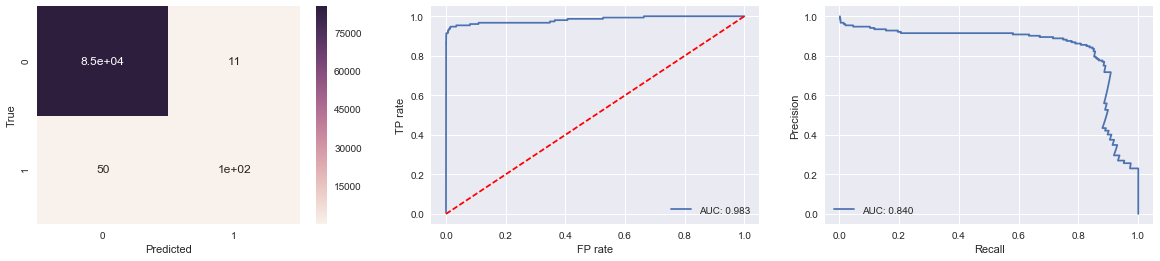

In [97]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(n_jobs=4)
lr_model.fit(train_X, train_y)

model_metrics(lr_model, test_X, test_y)

             precision    recall  f1-score   support

          0       1.00      0.97      0.99     85291
          1       0.06      0.95      0.11       152

avg / total       1.00      0.97      0.98     85443



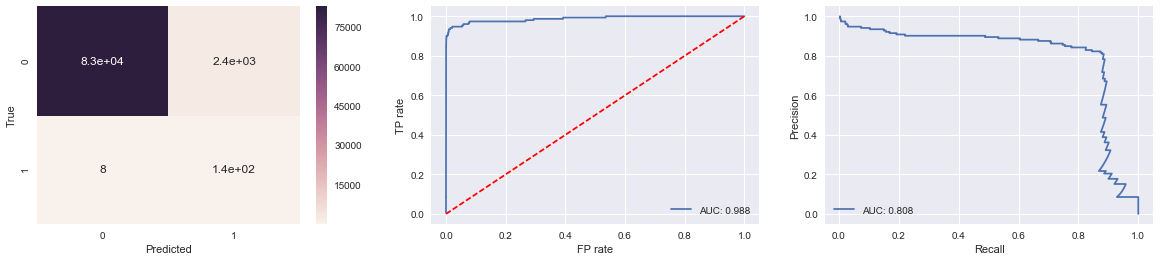

In [98]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(class_weight='balanced', n_jobs=4)
lr_model.fit(train_X, train_y)

model_metrics(lr_model, test_X, test_y)

### Undersampled data

In [164]:
import numpy as np

def undersample(data, n=1):
    positive_samples = data[data[target] == 1].copy().apply(np.random.permutation)
    negative_samples = data[data[target] == 0].copy().apply(np.random.permutation).head(positive_samples.shape[0] * n)

    undersampled_data = pd.concat([positive_samples, negative_samples])

    u_train_X, u_test_X, u_train_y, u_test_y = train_test_split(undersampled_data[feature_columns], undersampled_data[target], test_size=0.3)
    print('% fraud in population: ', undersampled_data[undersampled_data[target] == 1].shape[0] / undersampled_data.shape[0] * 100)
    print('Train - size:', u_train_y.shape[0], ', %fraud:', u_train_y[u_train_y == 1].shape[0] / u_train_y.shape[0] * 100)
    print('Test - size:', u_test_y.shape[0], ', %fraud: ', u_test_y[u_test_y == 1].shape[0] / u_test_y.shape[0] * 100)
    
    return u_train_X, u_test_X, u_train_y, u_test_y

u_train_X, u_test_X, u_train_y, u_test_y = undersample(data, 1)

% fraud in population:  50.0
Train - size: 688 , %fraud: 49.7093023255814
Test - size: 296 , %fraud:  50.67567567567568


             precision    recall  f1-score   support

          0       0.98      0.72      0.83       144
          1       0.79      0.99      0.88       152

avg / total       0.88      0.86      0.86       296



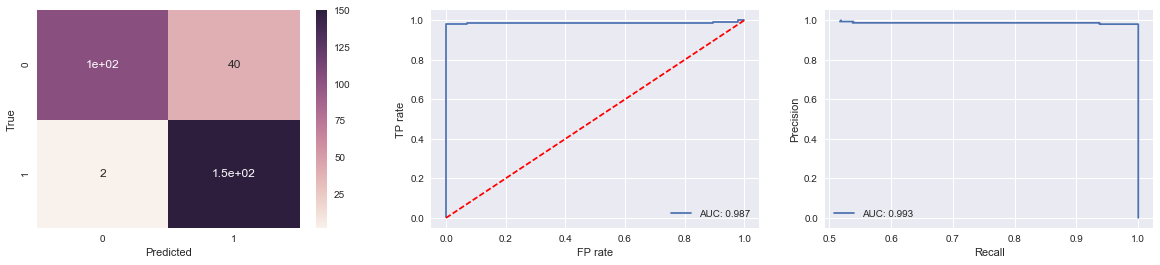

             precision    recall  f1-score   support

          0       1.00      0.86      0.92     85291
          1       0.01      0.95      0.02       152

avg / total       1.00      0.86      0.92     85443



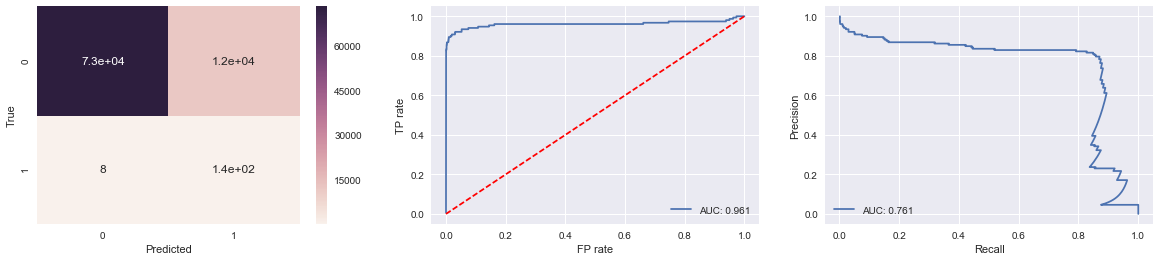

In [125]:
u_lr_model = LogisticRegression(C=0.0001, n_jobs=4)
u_lr_model.fit(u_train_X, u_train_y)

model_metrics(u_lr_model, u_test_X, u_test_y)
model_metrics(u_lr_model, test_X, test_y)

## SVM

In [196]:
from sklearn.svm import SVC

u_train_X, u_test_X, u_train_y, u_test_y = undersample(data, 1)

% fraud in population:  50.0
Train - size: 688 , %fraud: 50.58139534883721
Test - size: 296 , %fraud:  48.64864864864865


             precision    recall  f1-score   support

          0       1.00      0.82      0.90       152
          1       0.84      1.00      0.91       144

avg / total       0.92      0.91      0.90       296



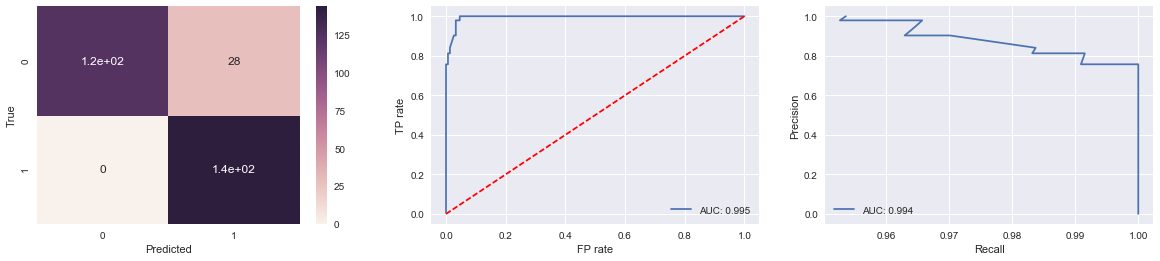

             precision    recall  f1-score   support

          0       1.00      0.84      0.91     85291
          1       0.01      0.93      0.02       152

avg / total       1.00      0.84      0.91     85443



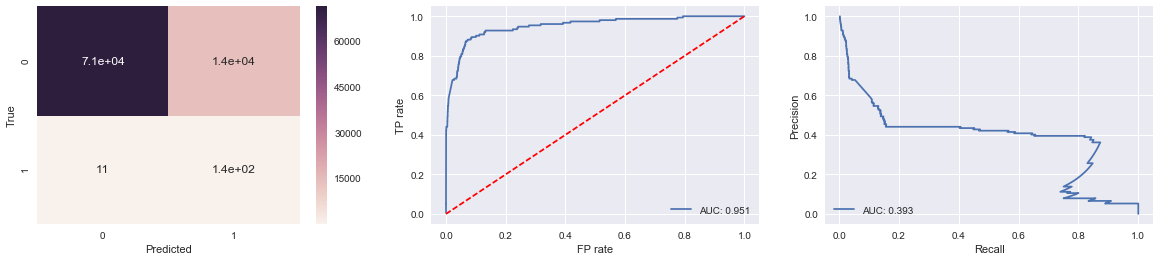

In [200]:
svc_model = SVC(C=10)
svc_model.fit(u_train_X, u_train_y)

model_metrics(svc_model, u_test_X, u_test_y)
model_metrics(svc_model, test_X, test_y)

## Random forest

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85291
          1       0.81      0.89      0.85       152

avg / total       1.00      1.00      1.00     85443



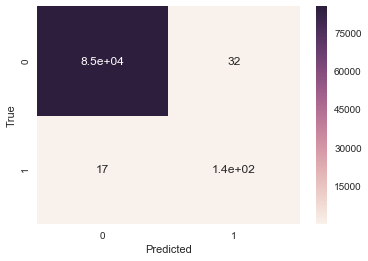

In [243]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('pca', PCA(n_components=16)),
    ('rf', RandomForestClassifier(n_estimators=25, max_depth=10, class_weight='balanced', n_jobs=8))
])


pipe.fit(train_X, train_y)

model_metrics(pipe, test_X, test_y, True)